# NeuroCluster:
<font size= 4> Non-parametric cluster-based permutation testing to identify neurophysiological encoding of continuous variables with time-frequency resolution

Authors: Christina Maher & Alexandra Fink-Skular \
Updated: 07/23/2024 by AFS

In [2]:
import numpy as np
import pandas as pd
import mne
from glob import glob
from scipy.stats import zscore #, t, linregress, ttest_ind, ttest_rel, ttest_1samp 
import os 
# import re
# import h5io
import pickle 
# import time 
import datetime 
from joblib import Parallel, delayed
import statsmodels.api as sm 
from scipy.ndimage import label 
import statsmodels.formula.api as smf
# from tqdm import tqdm
# import operator
# import tqdm

import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings('ignore')

# keep this so we can use our respective paths for testing
current_user = 'alie'

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
date = datetime.date.today().strftime('%m%d%Y')
print(date)

07242024


In [5]:
# path to sample data 
user_base_dir   = '/Users/alexandrafink/Documents/GraduateSchool/SaezLab/NeuroCluster/NeuroCluster/'
# user_base_dir   = '/Users/christinamaher/Documents/GitHub/NeuroCluster/'
sample_data_dir = f'{user_base_dir}NeuroCluster/data/'


In [6]:
# load functions 
import sys
sys.path.append(f'{user_base_dir}NeuroCluster/scripts/')
# sys.path.append(f'{base_dir}scripts/')

from tfr_cluster_test import *
from helper_utils import *
# from plotting_utils import * 

In [53]:
sample_ieeg_files = glob(f'{sample_data_dir}sample_ieeg/*')
sample_ieeg_dict = {f'{file.split("/")[-1].split(".")[0]}':np.load(file) for file in sample_ieeg_files}
ieeg_channels = list(sample_ieeg_dict.keys())
sample_behav = pd.read_csv(f'{sample_data_dir}sample_behavior.csv')

# Step 1: Format Input Data (Currently within-subject)
- neural input: np.array (n_channels x n_epochs x n_freqs x n_times)
- regressor data: np.array (numpy array: n_epochs x n_features)

In [9]:
# regression predictor variables 
multi_reg_vars = ['outcome','error']
# set main predictor of interest for permutations 
permute_var = 'error'
# subset input dataframe to include only multi_reg_vars
predictor_data = sample_behavior_data.copy()[multi_reg_vars]

In [10]:
predictor_data

,outcome,error
0,bad,1.92
1,good,0.60
2,good,0.20
3,bad,-0.40
4,bad,0.52
...,...,...
145,bad,-0.30
146,bad,-1.04
147,good,-0.15
148,bad,0.40


## Step 2: Find Real Clusters
- Use TFRClusterTest class code to run multivariate regression
- Allows for multiple regression implementation and pixel paralellization, so with more speed improvements will ultimately be worth it.

In [11]:
channel_idx = -3
# tfr_data = np.squeeze(sample_ieeg_data[:,channel_idx,:,:])
tfr_data = sample_ieeg_data[:,channel_idx,:,:]
tfr_data.shape

(150, 30, 1501)

In [12]:
tfr_data

array([[[-3.26030312e-01, -3.25036398e-01, -3.24084535e-01, ...,
         -8.96079278e-01, -8.98953229e-01, -9.01753982e-01],
        [-3.73720744e-01, -3.73428715e-01, -3.73198911e-01, ...,
         -9.66280646e-01, -9.67834332e-01, -9.69331670e-01],
        [-4.40485569e-01, -4.41871540e-01, -4.43304360e-01, ...,
         -9.83805941e-01, -9.84478954e-01, -9.85121533e-01],
        ...,
        [-7.89567053e-01, -8.34109484e-01, -8.58454170e-01, ...,
         -5.00428707e-01, -5.41717942e-01, -5.85504754e-01],
        [-5.79831248e-01, -6.49391308e-01, -7.18658730e-01, ...,
         -8.32153931e-01, -7.15932045e-01, -6.28187854e-01],
        [-9.03573370e-01, -9.54299469e-01, -9.92976831e-01, ...,
          2.00083276e-01,  1.00708727e-01, -3.97917525e-02]],

       [[-9.20396169e-01, -9.20117973e-01, -9.19836916e-01, ...,
         -4.43819147e-01, -4.49297283e-01, -4.54727411e-01],
        [-7.05371473e-01, -7.04289684e-01, -7.03212266e-01, ...,
         -3.10152560e-01, -3.17595718e

In [13]:
cluster_test  = TFR_Cluster_Test(tfr_data,predictor_data,permute_var)
cluster_test

In [14]:
betas, tstats = cluster_test.tfr_regression()


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 3336 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 42968 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 45030 out of 45030 | elapsed:    6.7s finished


In [15]:
tstats

array([[-2.22131272, -2.22208677, -2.22276524, ..., -1.16264999,
        -1.17445054, -1.1675014 ],
       [-1.99642359, -1.99648801, -1.99643455, ..., -1.25731521,
        -1.26857523, -1.26227752],
       [-1.90088174, -1.89824483, -1.89546561, ..., -1.32104702,
        -1.32764812, -1.31414075],
       ...,
       [ 0.7963352 ,  1.39923386,  1.87687716, ...,  0.92660442,
         0.92452367,  0.83596055],
       [-0.67685674, -0.3901508 , -0.0744696 , ..., -1.85567459,
        -1.69285143, -1.15136317],
       [ 0.16753696,  0.58494446,  0.84807153, ..., -1.32028571,
        -1.42805275, -1.4175704 ]])

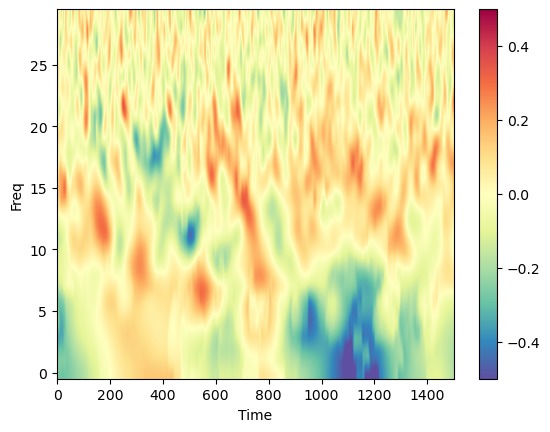

In [16]:
plt.imshow(betas, interpolation = 'Bicubic',cmap='Spectral_r', aspect='auto',origin='lower',vmin=-.5,vmax=.5) 
plt.colorbar()
plt.ylabel('Freq')
plt.xlabel('Time')
# plt.title(f'{power_epochs.ch_names[16]}')
plt.show()

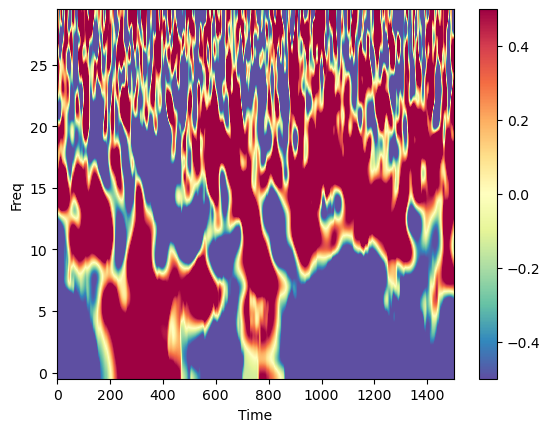

In [17]:
plt.imshow(tstats, interpolation = 'Bicubic',cmap='Spectral_r', aspect='auto',origin='lower',vmin=-.5,vmax=.5) 
plt.colorbar()
plt.ylabel('Freq')
plt.xlabel('Time')
# plt.title(f'{power_epochs.ch_names[16]}')
plt.show()

In [18]:
max_cluster_data  = cluster_test.max_tfr_cluster(tstats,output='all')


In [19]:
max_cluster_data

[{'cluster_stat': 604.1057189495974,
  'freq_idx': (8, 15),
  'time_idx': (687, 791)},
 {'cluster_stat': -4365.682918597544,
  'freq_idx': (0, 8),
  'time_idx': (928, 1273)}]

## Step 3: Compute Null Cluster Distribution from Permutations

In [20]:
null_cluster_distribution = cluster_test.compute_null_cluster_stats(num_permutations=50)

In [22]:
np.mean(null_cluster_distribution[0])

703.6534051104155

In [23]:
null_cluster_distribution

[[420.9312106162654,
  296.43133692594154,
  905.2747955018766,
  295.7138926468309,
  219.36431335252706,
  352.18428616083975,
  1778.3203520090533,
  198.82168257736112,
  726.4792046874061,
  706.3028538998051,
  667.9248553005282,
  1263.262036453432,
  942.2036389490638,
  667.3935780093872,
  865.7712156575603,
  945.6811257247739,
  382.8365348415118,
  221.23223250613995,
  580.0679045254556,
  389.25696034147313,
  851.9133556175863,
  649.8814233348446,
  322.33817479338916,
  489.82933930064166,
  717.5138010475034,
  323.9569945406404,
  854.7684571600255,
  902.1725661935491,
  409.5103791175434,
  967.6397896253328,
  2069.585371777952,
  357.96645075312216,
  927.7439014556527,
  451.3900955372478,
  273.80259170646195,
  819.5825936216082,
  641.9468597652738,
  457.8246529663413,
  1553.8411945709743,
  576.971219127905,
  577.8101590226318,
  813.2591563546258,
  2588.539777909241,
  874.4012238899279,
  461.2721108891408,
  432.6927085032322,
  394.9308053373238,
  

In [24]:
cluster_pvalue = cluster_test.cluster_significance_test(max_cluster_data,null_cluster_distribution) #compute_cluster_pvalue cluster_significance_test


In [25]:
cluster_pvalue

[0.52, 0.0]

#### POLISHED WORKFLOW

In [ ]:
### NeuroCluster single electrode workflow: 

# Step 1: Create TFR_Cluster_Test Object
cluster_test  = TFR_Cluster_Test(tfr_data,predictor_data,permute_var,ch_name,alternative='two-sided')

# Step 2: Run TFR regression to extract beta coefficients for predictor of interest (permute_var) & tstats for each pixel in TFR
betas, tstats = cluster_test.tfr_regression()

# Step 3: Find largest cluster(s) and return the max cluster statistic(s) and cluster's  frequencies x times indices
max_cluster_data  = cluster_test.max_tfr_cluster(tstats,output='all')

# Step 4: Create null distribution of maximum cluster statistics from permuted data
null_cluster_distribution = cluster_test.compute_null_cluster_stats(num_permutations=10)

# Step 5: Use null cluster statistic distribution from permutations to compute non-parametric p value 
cluster_pvalue = cluster_test.cluster_significance_test(max_cluster_data,null_cluster_distribution,alpha=0.05) #compute_cluster_pvalue cluster_significance_test



In [ ]:
# To implement FDR correction: 
# https://www.statsmodels.org/dev/generated/statsmodels.stats.multitest.multipletests.html
# multitest.multipletests(p_upper, method='fdr_bh')